In [1]:
import numpy as np 
import pandas as pd 
from scipy.stats import binom
import matplotlib.pyplot as plt

In [5]:
# Loading Data
FICO_df = pd.read_csv('Task 3 and 4_Loan_Data.csv')
FICO_df

,customer_id,credit_lines_outstanding,loan_amt_outstanding,total_debt_outstanding,income,years_employed,fico_score,default
0,8153374,0,5221.545193,3915.471226,78039.38546,5,605,0
1,7442532,5,1958.928726,8228.752520,26648.43525,2,572,1
2,2256073,0,3363.009259,2027.830850,65866.71246,4,602,0
3,4885975,0,4766.648001,2501.730397,74356.88347,5,612,0
4,4700614,1,1345.827718,1768.826187,23448.32631,6,631,0
...,...,...,...,...,...,...,...,...
9995,3972488,0,3033.647103,2553.733144,42691.62787,5,697,0
9996,6184073,1,4146.239304,5458.163525,79969.50521,8,615,0
9997,6694516,2,3088.223727,4813.090925,38192.67591,5,596,0
9998,3942961,0,3288.901666,1043.099660,50929.37206,2,647,0


In [11]:
# Initialize 5 buckets for simplicity
num_buckets = 4
FICO_df['bucket'] = pd.cut(FICO_df['fico_score'], bins=num_buckets, labels=False)

FICO_df

,customer_id,credit_lines_outstanding,loan_amt_outstanding,total_debt_outstanding,income,years_employed,fico_score,default,bucket
0,8153374,0,5221.545193,3915.471226,78039.38546,5,605,0,1
1,7442532,5,1958.928726,8228.752520,26648.43525,2,572,1,1
2,2256073,0,3363.009259,2027.830850,65866.71246,4,602,0,1
3,4885975,0,4766.648001,2501.730397,74356.88347,5,612,0,1
4,4700614,1,1345.827718,1768.826187,23448.32631,6,631,0,2
...,...,...,...,...,...,...,...,...,...
9995,3972488,0,3033.647103,2553.733144,42691.62787,5,697,0,2
9996,6184073,1,4146.239304,5458.163525,79969.50521,8,615,0,1
9997,6694516,2,3088.223727,4813.090925,38192.67591,5,596,0,1
9998,3942961,0,3288.901666,1043.099660,50929.37206,2,647,0,2


In [12]:
FICO_df['bucket'].value_counts()

bucket
2    5149
1    4137
3     431
0     283
Name: count, dtype: int64

Initial log-likelihood: -13.463435690611455


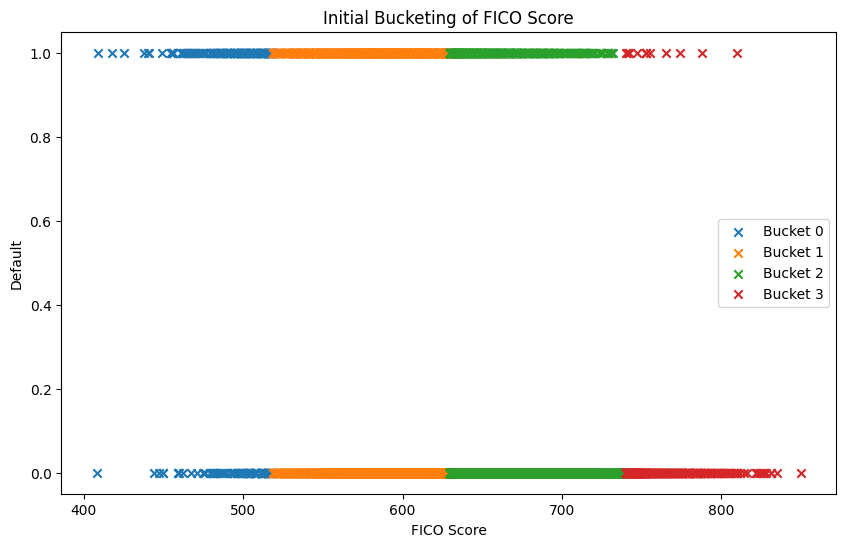

In [14]:
# Initialize the bucket boundaries
# Calculate the initial log-likelihood

def calculate_log_likelihood(data):
    log_likelihood = 0
    for b in range(num_buckets):
        bucket_data = FICO_df[FICO_df['bucket'] == b]
        if not bucket_data.empty:
            ni = len(bucket_data)
            ki = bucket_data['default'].sum()
            pi = ki/ni if ni> 0 else 0
            log_likelihood += binom.logpmf(ki,ni,pi)
    return log_likelihood

initial_log_likelihood = calculate_log_likelihood(FICO_df)

print(f"Initial log-likelihood: {initial_log_likelihood}")

# Plotting the initial Bucketing
plt.figure(figsize=(10,6))
for b in range(num_buckets):
    bucket_data = FICO_df[FICO_df['bucket'] == b]
    plt.scatter(bucket_data['fico_score'], bucket_data['default'], label=f'Bucket {b}', marker = 'x')
plt.xlabel('FICO Score')
plt.ylabel('Default')
plt.legend()
plt.title('Initial Bucketing of FICO Score')
plt.show()

In [20]:
# Bucket Optimization 

def optimize_buckets(data, num_buckets, max_iterations = 100):
    boundaries = np.linspace(FICO_df['fico_score'].min(), FICO_df['fico_score'].max(), num_buckets +1)
    best_likelihood = calculate_log_likelihood(data)
    improved = True
    iteration = 0

    while improved and iteration < max_iterations:
        improved = False
        for i in range(1,len(boundaries)-1): # adjust internal boundaries only 
            original_boundary = boundaries[i]
        # Try shifting the boundary up and down 
        for shift in [-10,10]:
            boundaries[i] += shift
            FICO_df['bucket']  = pd.cut(FICO_df['fico_score'], bins=boundaries, labels=False, include_lowest=True)
            new_likelihood = calculate_log_likelihood(data)
            if new_likelihood > best_likelihood:
                best_likelihood = new_likelihood
                improved = True
            else:
                boundaries[i] = original_boundary 
        iteration += 1
        print(f"Iteration{iteration}, log-likelihood: {best_likelihood}")

    return boundaries        

In [22]:
# Optimize the buckets
final_boundaries = optimize_buckets(FICO_df, num_buckets)

# Update the data with the optimizaed buckets
FICO_df['bucket'] = pd.cut(FICO_df['fico_score'], bins=final_boundaries, labels=False, include_lowest=True)
final_boundaries

Iteration1, log-likelihood: -11.285971818143054


array([408. , 518.5, 629. , 739.5, 850. ])